# Product Review Classification

## Business Understanding
Our company wants a tool that will automatically classify product reviews as _positive_ or _negative_ reviews, based on the features of the review.  This will help our Product team to perform more sophisticated analyses in the future to help ensure customer satisfaction.

## Data Understanding
We have a labeled collection of 20,000 product reviews, with an equal split of positive and negative reviews. The dataset contains the following features:

 - `ProductId` Unique identifier for the product
 - `UserId` Unqiue identifier for the user
 - `ProfileName` Profile name of the user
 - `HelpfulnessNumerator` Number of users who found the review helpful
 - `HelpfulnessDenominator` Number of users who indicated whether they found the review helpful or not
 - `Time` Timestamp for the review
 - `Summary` Brief summary of the review
 - `Text` Text of the review
 - `PositiveReview` 1 if this was labeled as a positive review, 0 if it was labeled as a negative review

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [120]:
import time
from datetime import timedelta

In [2]:
df = pd.read_csv("reviews.csv")
df.head(3)

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,PositiveReview
0,B002QWHJOU,A37565LZHTG1VH,C. Maltese,1,1,1305331200,Awesome!,This is a great product. My 2 year old Golden ...,1
1,B000ESLJ6C,AMUAWXDJHE4D2,angieseashore,1,1,1320710400,Was there a recipe change?,I have been drinking Pero ever since I was a l...,0
2,B004IJJQK4,AMHHNAFJ9L958,A M,0,1,1321747200,These taste so bland.,"Look, each pack contains two servings of 120 c...",0


In [24]:
df.dtypes

ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Time                       int64
Summary                   object
Text                      object
PositiveReview             int64
dtype: object

The data has already been cleaned, so there are no missing values

In [3]:
df.isna().sum()

ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Time                      0
Summary                   0
Text                      0
PositiveReview            0
dtype: int64

`PositiveReview` is the target, and all other columns are features

In [4]:
X = df.drop("PositiveReview", axis=1)
y = df["PositiveReview"]

## Data Preparation

First, split into train and test sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.shape

(15000, 8)

Second, prepare for modeling. The following `Pipeline` prepares all data for modeling.  It one-hot encodes the `ProductId`, applies a tf-idf vectorizer to the `Summary` and `Text`, keeps the numeric columns as-is, and drops all other columns.

The following code may take up to 1 minute to run.

In [6]:
def drop_irrelevant_columns(X):
    return X.drop(["UserId", "ProfileName"], axis=1)

pipeline = Pipeline(steps=[
    ("drop_columns", FunctionTransformer(drop_irrelevant_columns)),
    ("transform_text_columns", ColumnTransformer(transformers=[
        ("ohe", OneHotEncoder(categories="auto", handle_unknown="ignore", sparse=False), ["ProductId"]),
        ("summary-tf-idf", TfidfVectorizer(max_features=1000), "Summary"),
        ("text-tf-idf", TfidfVectorizer(max_features=1000), "Text")
    ], remainder="passthrough"))
])

X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

X_train_transformed.shape

(15000, 11275)

## Modeling

Fit a `RandomForestClassifier` with the best hyperparameters.  The following code may take up to 1 minute to run.

In [124]:
start_time = time.time()

rfc = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=30,
    min_samples_split=15,
    min_samples_leaf=1
)
rfc.fit(X_train_transformed, y_train)

elapsed_time_secs = time.time() - start_time
msg = "Execution took: %s secs (Wall clock time)" % timedelta(seconds=round(elapsed_time_secs))
print(msg) 

Execution took: 0:00:47 secs (Wall clock time)


## Model Evaluation

We are using _accuracy_ as our metric, which is the default metric in Scikit-Learn, so it is possible to just use the built-in `.score` method

In [8]:
print("Train accuracy:", rfc.score(X_train_transformed, y_train))
print("Test accuracy:", rfc.score(X_test_transformed, y_test))

Train accuracy: 0.9826666666666667
Test accuracy: 0.913


In [9]:
print("Train confusion matrix:")
print(confusion_matrix(y_train, rfc.predict(X_train_transformed)))
print("Test confusion matrix:")
print(confusion_matrix(y_test, rfc.predict(X_test_transformed)))

Train confusion matrix:
[[7312  177]
 [  83 7428]]
Test confusion matrix:
[[2293  218]
 [ 217 2272]]


## Business Interpretation

The tuned Random Forest Classifier model appears to be somewhat overfit on the training data, but nevertheless achieves 91% accuracy on the test data.  Of the 9% of mislabeled comments, about half are false positives and half are false negatives.

Because this is a balanced dataset, 91% accuracy is a substantial improvement over a 50% baseline.  This model is ready for production use for decision support.

## Please add you work below.
> Rubric items have been provided as guidance. 

### 1) Data Preparation

A train-test split has already been performed.

Additionally, there is already a pipeline in place that drops some columns and converts all text columns into a numeric format for modeling.

**Your only additional data preparation task is feature scaling.**  Tree-based models like Random Forest Classifiers do not require scaling, but TensorFlow neural networks do.

There are two main strategies you can take for this task:

#### Scaling within the existing pipeline

If you are comfortable with pipelines, this is the more polished/professional route.

1. Make a new pipeline, with a `StandardScaler` as the final step.  You can nest the steps of the previous pipeline inside of this new pipeline
2. Generate a new `X_train_transformed_scaled` by calling `.fit_transform` on the new pipeline
3. Generate a new `X_test_transformed_scaled` by calling `.transform` on the new pipeline

#### Scaling after the pipeline has finished

This is a better strategy if you are not as comfortable with pipelines.

1. Instantiate a `StandardScaler` object
2. Generate a new `X_train_transformed_scaled` by calling `.fit_transform` on the scaler object, after you have called `.fit_transform` on the pipeline
3. Generate a new `X_test_transformed_scaled` by calling `.transform` on the scaler object, after you have called `.transform` on the pipeline

If you are getting stuck at this step, skip it.  The model will still be able to fit, although the performance will be worse.  Keep in mind whether or not you scaled the data in your final analysis.

In [69]:
#Second split
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.25)

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector

In [34]:
pipeline2 = Pipeline(steps=[
    ("drop_columns", FunctionTransformer(drop_irrelevant_columns)),
    ("transform_text_columns", ColumnTransformer(transformers=[
        ("ohe", OneHotEncoder(categories="auto", handle_unknown="ignore", sparse=False), ["ProductId"]),
        ("summary-tf-idf", TfidfVectorizer(max_features=1000), "Summary"),
        ("text-tf-idf", TfidfVectorizer(max_features=1000), "Text"),
        ("ss", StandardScaler(), make_column_selector(dtype_include=np.number))
    ], remainder="passthrough"))
])

In [70]:
X_train_transformed_scaled = pipeline2.fit_transform(X_train)
X_test_transformed_scaled = pipeline2.transform(X_test)
X_val_transformed_scaled= pipeline2.transform(X_val)

X_train_transformed_scaled.shape

(15000, 11275)

### 2) Modeling

Build a neural network classifier.  Specifically, use the `keras` submodule of the `tensorflow` library to build a multi-layer perceptron model with the `Sequential` interface.

See the [`tf.keras` documentation](https://www.tensorflow.org/guide/keras/overview) for an overview on the use of `Sequential` models. See the [Keras layers documentation](https://keras.io/layers/core/) for descriptions of the `Dense` layer options.  

1. Instantiate a `Sequential` model
2. Add an input `Dense` layer.  You'll need to specify a `input_shape` = (11275,) because this is the number of features of the transformed dataset.
3. Add 2 `Dense` hidden layers.  They can have any number of units, but keep in mind that more units will require more processing power.  We recommend an initial `units` of 64 for processing power reasons.
4. Add a final `Dense` output layer.  This layer must have exactly 1 unit because we are doing a binary prediction task.
5. Compile the `Sequential` model
6. Fit the `Sequential` model on the preprocessed training data (`X_train_transformed_scaled`) with a b`batch_size` of 50 and `epochs` of 5 for processing power reasons.


In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [86]:
model = Sequential()

In [87]:
input_shape_ss = X_train_transformed_scaled.shape[1]
input_shape_ss

11275

In [88]:
# Input layer
model.add(Dense(units=64, activation='relu', input_shape=(input_shape_ss,)))

In [89]:
# Hidden layer
model.add(Dense(units=64, activation='relu', input_shape=(input_shape_ss,)))

In [90]:
# Since we have binary target, we use just 1 neuron and 'sigmoid' activation function for output layer
model.add(Dense(1, activation='sigmoid'))

# type 1 error: Detecting positive review when in fact it is negative review
# type 2 error: Detecting negative review when in fact it is positive review
# accuracy = TP + TN/(TP + FN + TN + FP)

In [91]:
# Model compilation
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [92]:
# Let's fit a FSM neural net
model.fit(X_train_transformed_scaled, y_train, epochs=5, batch_size=50)

Epoch 1/5
300/300 [==============================] - 1s 3ms/step - loss: 0.2443 - accuracy: 0.9099
Epoch 2/5
300/300 [==============================] - 1s 3ms/step - loss: 0.0676 - accuracy: 0.9787
Epoch 3/5
300/300 [==============================] - 1s 3ms/step - loss: 0.0275 - accuracy: 0.9933
Epoch 4/5
300/300 [==============================] - 1s 3ms/step - loss: 0.0142 - accuracy: 0.9971
Epoch 5/5
300/300 [==============================] - 1s 3ms/step - loss: 0.0067 - accuracy: 0.9987


In [93]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 64)                721664    
_________________________________________________________________
dense_26 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 65        
Total params: 725,889
Trainable params: 725,889
Non-trainable params: 0
_________________________________________________________________


### 3) Model Tuning + Feature Engineering

If you are running out of time, skip this step.

Tune the neural network model to improve performance.  This could include steps such as increasing the units, changing the activation functions, or adding regularization.

We recommend using using a `validation_split` of 0.1 to understand model performance without utilizing the test holdout set.

You can also return to the preprocessing phase, and add additional features to the model.

In [109]:
model = Sequential()

In [110]:
model.add(Dense(units=64, activation='tanh', input_shape=(input_shape_ss,)))
model.add(Dense(units=64, activation='tanh'))

In [111]:
model.add(Dense(1, activation='sigmoid'))

In [112]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [113]:
model.fit(X_train_transformed_scaled, y_train, validation_split=0.10, epochs=5, batch_size=50)

Epoch 1/5
270/270 [==============================] - 1s 5ms/step - loss: 0.2137 - accuracy: 0.9190 - val_loss: 0.1461 - val_accuracy: 0.9513
Epoch 2/5
270/270 [==============================] - 1s 4ms/step - loss: 0.1006 - accuracy: 0.9647 - val_loss: 0.1569 - val_accuracy: 0.9507
Epoch 3/5
270/270 [==============================] - 1s 4ms/step - loss: 0.0794 - accuracy: 0.9738 - val_loss: 0.1658 - val_accuracy: 0.9440
Epoch 4/5
270/270 [==============================] - 1s 4ms/step - loss: 0.0680 - accuracy: 0.9792 - val_loss: 0.1713 - val_accuracy: 0.9440
Epoch 5/5
270/270 [==============================] - 1s 4ms/step - loss: 0.0599 - accuracy: 0.9818 - val_loss: 0.1722 - val_accuracy: 0.9407


### 4) Model Evaluation

Choose a final `Sequential` model, add layers, and compile.  Fit the model on the preprocessed training data (`X_train_transformed_scaled`, `y_train`) and evaluate on the preprocessed testing data (`X_test_transformed_scaled`, `y_test`) using `accuracy_score`.

In [123]:
start_time = time.time()

# Final model evaluation
model = Sequential()
model.add(Dense(units=64, activation='tanh', input_shape=(input_shape_ss,)))
model.add(Dense(units=10, activation='tanh'))
model.add(Dense(units=8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_transformed_scaled, y_train, validation_data=(X_val_transformed_scaled, y_val), epochs=5, batch_size=50)


elapsed_time_secs = time.time() - start_time
msg = "Execution took: %s secs (Wall clock time)" % timedelta(seconds=round(elapsed_time_secs))
print(msg) 

Epoch 1/5
300/300 [==============================] - 2s 6ms/step - loss: 0.2452 - accuracy: 0.9185 - val_loss: 0.0929 - val_accuracy: 0.9701
Epoch 2/5
300/300 [==============================] - 1s 5ms/step - loss: 0.0995 - accuracy: 0.9654 - val_loss: 0.0664 - val_accuracy: 0.9787
Epoch 3/5
300/300 [==============================] - 1s 5ms/step - loss: 0.0796 - accuracy: 0.9744 - val_loss: 0.0580 - val_accuracy: 0.9829
Epoch 4/5
300/300 [==============================] - 1s 5ms/step - loss: 0.0685 - accuracy: 0.9797 - val_loss: 0.0509 - val_accuracy: 0.9853
Epoch 5/5
300/300 [==============================] - 1s 5ms/step - loss: 0.0612 - accuracy: 0.9817 - val_loss: 0.0472 - val_accuracy: 0.9867
Execution took: 0:00:09 secs (Wall clock time)


In [115]:
model.predict(X_test_transformed_scaled)

array([[0.9980031 ],
       [0.00372061],
       [0.99779755],
       ...,
       [0.9982534 ],
       [0.0057084 ],
       [0.01644191]], dtype=float32)

In [116]:
y_hat_test = model.predict_classes(X_test_transformed_scaled)

In [55]:
from sklearn.metrics import accuracy_score

In [117]:
cm = confusion_matrix(y_test, y_hat_test)
cm

array([[2397,  114],
       [ 143, 2346]])

In [118]:
accuracy_score(y_test, y_hat_test)

0.9486

In [125]:
model.history.history

{'loss': [0.24515827000141144,
  0.09951528906822205,
  0.07963597029447556,
  0.068495973944664,
  0.06116862967610359],
 'accuracy': [0.9185333251953125,
  0.965399980545044,
  0.974399983882904,
  0.9796666502952576,
  0.9816666841506958],
 'val_loss': [0.0928862988948822,
  0.06639716029167175,
  0.05797884613275528,
  0.05088489502668381,
  0.04715711250901222],
 'val_accuracy': [0.9701333045959473,
  0.9786666631698608,
  0.9829333424568176,
  0.9853333234786987,
  0.9866666793823242]}

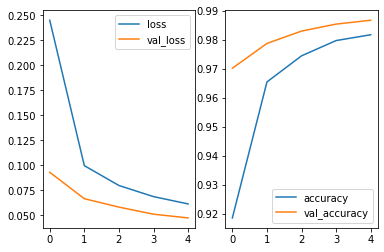

In [128]:
#__SOLUTION__

def plot_results(model):
    fig, (ax1,ax2) = plt.subplots(1,2)

    ax1.plot(model.history.epoch, model.history.history['loss'], label='loss')
    ax1.plot(model.history.epoch, model.history.history['val_loss'], label='val_loss')
    
    ax1.legend()
    
    ax2.plot(model.history.epoch, model.history.history['accuracy'], label='accuracy')
    ax2.plot(model.history.epoch, model.history.history['val_accuracy'], label='val_accuracy')

    ax2.legend()
    
    
plot_results(model)


### 5) Technical Communication

Write a paragraph explaining whether Northwind Trading Company should switch to using your new neural network model, or continue to use the Random Forest Classifier.  Beyond a simple comparison of performance, try to take into consideration additional considerations such as:

 - Computational complexity/resource use
 - Anticipated performance on future datasets (how might the data change over time?)
 - Types of mistakes made by the two kinds of models

You can make guesses or inferences about these considerations.

**Include at least one visualization** comparing the two types of models.  Possible points of comparison could include ROC curves, colorized confusion matrices, or time needed to train.


In [72]:
from sklearn.metrics import plot_confusion_matrix

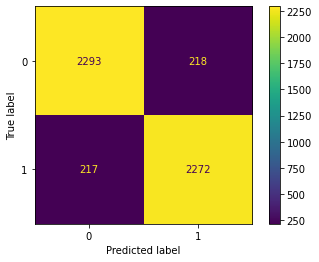

In [74]:
plot_confusion_matrix(rfc, X_test_transformed, y_test)

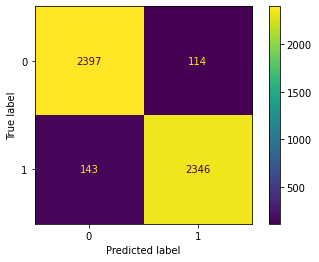

In [119]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp = disp.plot()
plt.show()

I would recomment to the Northwind Trading Company switching to using neural network model. It performs better than random forest model if we look at the results. Neural network model predicts with 94% accuracy on the test data versus 91% accuracy with Random Forest. Also, we were able to reduce false preditions for about 40% as you can see from the plots above of confusion matrixes. With more reviews receiving in the future data will get only bigger, so time spend on model performing will get more critical. For current data, computational time is faster, neural network model's execution time is 9 seconds for final model versus 47 seconds for RFC final model. Overfitting problem can be controlled better with neural network model as well.
In conclusion, if the company is planning to expand I highly recommend them to switch to neural network model. 